<a href="https://colab.research.google.com/github/dcpatton/cassava_disease_classification/blob/master/Kaggle_cassava.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cassava Disease Classifcation


 https://arxiv.org/pdf/1908.02900.pdf

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import random
print(tf.__version__)
print(hub.__version__)

seed = 51
tf.random.set_seed(seed)
random.seed(seed)

2.2.0
0.8.0


# Upload Kaggle credentials

In [1]:
# upload the kaggle.json file from local computer
from google.colab import files
files.upload()

{}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)


In [ ]:
!ls -l /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

-rw-r--r-- 1 root root 64 Jul 25 12:41 /root/.kaggle/kaggle.json


# Download competition files from Kaggle

In [ ]:
!kaggle competitions download -c cassava-disease -f train.zip
!kaggle competitions download -c cassava-disease -f test.zip
!kaggle competitions download -c cassava-disease -f sample_submission_file.csv

 98% 761M/777M [00:11<00:00, 69.1MB/s]
100% 777M/777M [00:11<00:00, 70.1MB/s]
 98% 505M/515M [00:07<00:00, 62.1MB/s]
100% 515M/515M [00:07<00:00, 70.2MB/s]
  0% 0.00/83.8k [00:00<?, ?B/s]
100% 83.8k/83.8k [00:00<00:00, 30.9MB/s]


In [ ]:
!unzip train.zip > /dev/null
!unzip test.zip > /dev/null

# Prepare the training and validation data

Note that 20% of the test data is used for validation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

imageDataGenerator = ImageDataGenerator(rescale=1/255.,
                                        rotation_range=45,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        zoom_range=0.2,
                                        shear_range=10,
                                        validation_split=0.2,
                                       )

train_gen = imageDataGenerator.flow_from_directory('/content/train/', target_size=(380, 380), subset='training',
                                                   class_mode='categorical', batch_size=32, shuffle=True)

val_gen = imageDataGenerator.flow_from_directory('/content/train/', target_size=(380, 380), subset='validation',
                                                  class_mode='categorical', batch_size=32, shuffle=False)

Found 4527 images belonging to 5 classes.
Found 1129 images belonging to 5 classes.


In [ ]:
num_classes = 5

# Define the model

The model is based on EfficientNet B4

In [ ]:
from tensorflow.keras.layers import Dense, InputLayer, Dropout
from tensorflow.keras.optimizers import Adam

MODULE_HANDLE = "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1"

IMAGE_SIZE = (380, 380)

model = tf.keras.Sequential([
    InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=False),
    Dense(512, activation='relu'),
    Dropout(0.33),
    Dense(256, activation='relu'),
    Dropout(0.33),
    Dense(128, activation='relu'),
    Dropout(0.33),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1792)              17673816  
_________________________________________________________________
dense (Dense)                (None, 512)               918016    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0

In [ ]:
for layer in model.layers:
  print(layer.name + ':  ' + str(layer.trainable))

keras_layer:  False
dense:  True
dropout:  True
dense_1:  True
dropout_1:  True
dense_2:  True
dropout_2:  True
dense_3:  True


# Train the model

Recommended to use a GPU. Save the best weights in a checkpoint file for later use.

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_filepath = 'model.h5'
mc = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, verbose=1, 
                                        save_weights_only=True, monitor='val_loss', 
                                        mode='auto', save_best_only=True)

history = model.fit(train_gen, epochs=50, verbose=1, callbacks=[mc], validation_data=val_gen)

Epoch 1/50
142/142 [==============================] - ETA: 0s - loss: 1.0182 - acc: 0.6240
Epoch 00001: val_loss improved from inf to 0.83049, saving model to model.h5
142/142 [==============================] - 199s 1s/step - loss: 1.0182 - acc: 0.6240 - val_loss: 0.8305 - val_acc: 0.7077
Epoch 2/50
142/142 [==============================] - ETA: 0s - loss: 0.8470 - acc: 0.6903
Epoch 00002: val_loss improved from 0.83049 to 0.70935, saving model to model.h5
142/142 [==============================] - 196s 1s/step - loss: 0.8470 - acc: 0.6903 - val_loss: 0.7094 - val_acc: 0.7449
Epoch 3/50
142/142 [==============================] - ETA: 0s - loss: 0.7825 - acc: 0.7219
Epoch 00003: val_loss improved from 0.70935 to 0.68767, saving model to model.h5
142/142 [==============================] - 194s 1s/step - loss: 0.7825 - acc: 0.7219 - val_loss: 0.6877 - val_acc: 0.7520
Epoch 4/50
142/142 [==============================] - ETA: 0s - loss: 0.7426 - acc: 0.7387
Epoch 00004: val_loss did not i

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


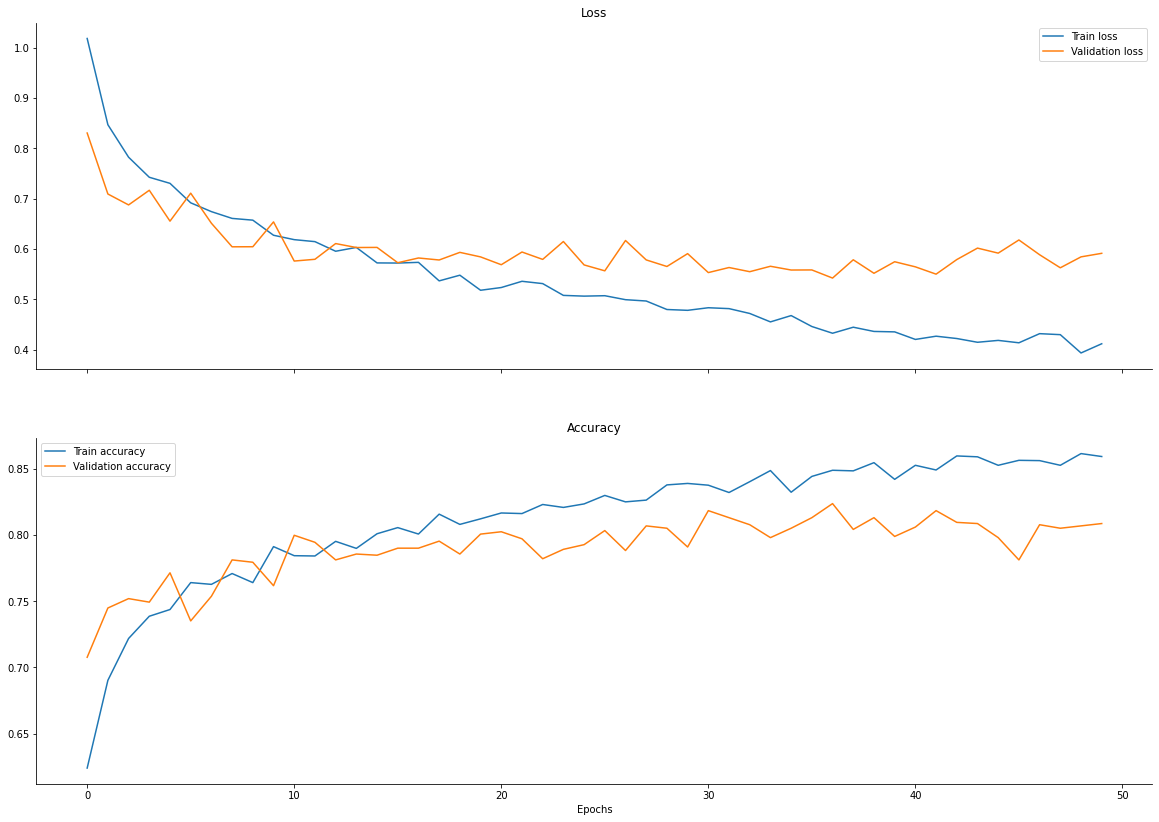

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

history = history.history

fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['acc'], label='Train accuracy')
ax2.plot(history['val_acc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [ ]:
# Reload the best weights from the checkpoint file
model.load_weights(checkpoint_filepath)

# Prepare the test data

In [ ]:
imageDataGenerator = ImageDataGenerator(rescale=1/255.)

test_gen = imageDataGenerator.flow_from_directory('/content/test/', target_size=(380, 380),
                                                  class_mode=None, batch_size=32, shuffle=False)

Found 3774 images belonging to 1 classes.


# Make predictions for the test data

Note that these predictions are probabilities for each class

In [ ]:
predictions = model.predict(test_gen, verbose=1)

118/118 [==============================] - 39s 327ms/step


# Prepare Kaggle submission file

Use the highest probable class as the submitted Category.

In [ ]:
import numpy as np
import pandas as pd

_predicted_classes = [np.argmax(predictions[i]) for i in range(len(predictions))]
_class_labels = np.array(['cbb','cbsd','cgm','cmd','healthy'])
_predicted_class_labels = _class_labels[_predicted_classes]

submission = pd.read_csv('/content/sample_submission_file.csv')
print(submission.head())

filenames = test_gen.filenames
new_ids = []
for filename in filenames:
  new_ids.append(filename.replace('0/', ''))

submission['Category'] = _predicted_class_labels
submission['Id'] = new_ids
print(submission.head())

submission.to_csv('submission.csv', index=False)

print(len(submission))

  Category              Id
0     cbsd  test-img-0.jpg
1      cmd  test-img-1.jpg
2      cbb  test-img-2.jpg
3      cmd  test-img-3.jpg
4     cbsd  test-img-4.jpg
  Category                 Id
0     cbsd     test-img-0.jpg
1     cbsd     test-img-1.jpg
2      cmd    test-img-10.jpg
3      cmd   test-img-100.jpg
4     cbsd  test-img-1000.jpg
3774


# Submit to Kaggle

To see the score, login to the competion on Kaggle

In [ ]:
# submit the file to kaggle
!kaggle competitions submit cassava-disease -f submission.csv -m "Dropout(0.33)"

100% 81.7k/81.7k [00:02<00:00, 31.9kB/s]
Successfully submitted to Cassava Disease Classification 